<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Linear-SVC" data-toc-modified-id="Linear-SVC-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Linear SVC</a></span></li><li><span><a href="#LGBM-Classifier" data-toc-modified-id="LGBM-Classifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LGBM Classifier</a></span></li><li><span><a href="#Проверка-лучшей-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-лучшей-модели-на-тестовой-выборке-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Проверка лучшей модели на тестовой выборке</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install wordcloud
from wordcloud import WordCloud
import sklearn as sk
import numpy as np
import re

import nltk.corpus
from nltk.corpus import stopwords
import string
from nltk import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

RANDOM_STATE=42

In [ ]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [ ]:
print(df.info())
print()
print(df.describe())
print()
print(df.isnull().sum())
print()
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None

          Unnamed: 0          toxic
count  159292.000000  159292.000000
mean    79725.697242       0.101612
std     46028.837471       0.302139
min         0.000000       0.000000
25%     39872.750000       0.000000
50%     79721.500000       0.000000
75%    119573.250000       0.000000
max    159450.000000       1.000000

Unnamed: 0    0
text          0
toxic         0
dtype: int64

0


Дубликаты отсутствуют, пропуски отсутствуют, данные готовы к дальнейшему анализу. 

Теперь посмотрим как распределен целевой признак.

<AxesSubplot:xlabel='toxic', ylabel='count'>

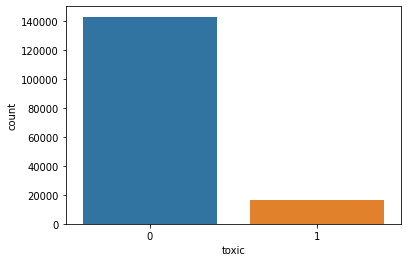

In [ ]:
sns.countplot(x='toxic', data=df)

In [ ]:
# для начала приведем все комментарии к нижнему регистру
df['text'] = df['text'].str.lower()

Переходим к предобработке текста и начнем с очистки его от стоп слов и знаков пунктуации.

In [ ]:
nltk.download('stopwords')
stopwords = stopwords.words("english")
stopwords

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
# функция очистки текста от стоп слов
def cleaning_stopwords(text):
    return " ".join([word for word in text.split() if word not in stopwords])

df['text'] = df['text'].apply(lambda text: cleaning_stopwords(text))

In [ ]:
english_punctuation = string.punctuation

# функция очистки от пунктуации
def cleaning_punctuation(text):
    translator = str.maketrans('','', english_punctuation)
    return text.translate(translator)

df['text'] = df['text'].apply(lambda x: cleaning_punctuation(x))

In [ ]:
# уберем цифры из текста комментариев 
def cleaning_numbers(data):
    return re.sub('[0-9]+',"", data)

df['text'] = df['text'].apply(lambda x: cleaning_numbers(x))

In [ ]:
df

,Unnamed: 0,text,toxic
0,0,explanation edits made username hardcore metal...,0
1,1,daww matches background colour im seemingly st...,0
2,2,hey man im really trying edit war guy constant...,0
3,3,cant make real suggestions improvement wonde...,0
4,4,you sir hero chance remember page thats on,0
...,...,...,...
159287,159446,and second time asking view completely contrad...,0
159288,159447,ashamed horrible thing put talk page,0
159289,159448,spitzer umm theres actual article prostitution...,0
159290,159449,looks like actually put speedy first version d...,0


Итак, теперь перейдем к токенизации и лемматизации текста.

In [ ]:
# токенизация
df['text'] = df['text'].apply(word_tokenize)

In [ ]:
# лемматизация
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

lm = nltk.WordNetLemmatizer()

def lemmatize(data):
    text = [lm.lemmatize(word, get_wordnet_pos(word)) for word in data]
    return data

df['text'] = df['text'].apply(lambda x: lemmatize(x))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df

,Unnamed: 0,text,toxic
0,0,"[explanation, edits, made, username, hardcore,...",0
1,1,"[daww, matches, background, colour, im, seemin...",0
2,2,"[hey, man, im, really, trying, edit, war, guy,...",0
3,3,"[cant, make, real, suggestions, improvement, w...",0
4,4,"[you, sir, hero, chance, remember, page, thats...",0
...,...,...,...
159287,159446,"[and, second, time, asking, view, completely, ...",0
159288,159447,"[ashamed, horrible, thing, put, talk, page]",0
159289,159448,"[spitzer, umm, theres, actual, article, prosti...",0
159290,159449,"[looks, like, actually, put, speedy, first, ve...",0


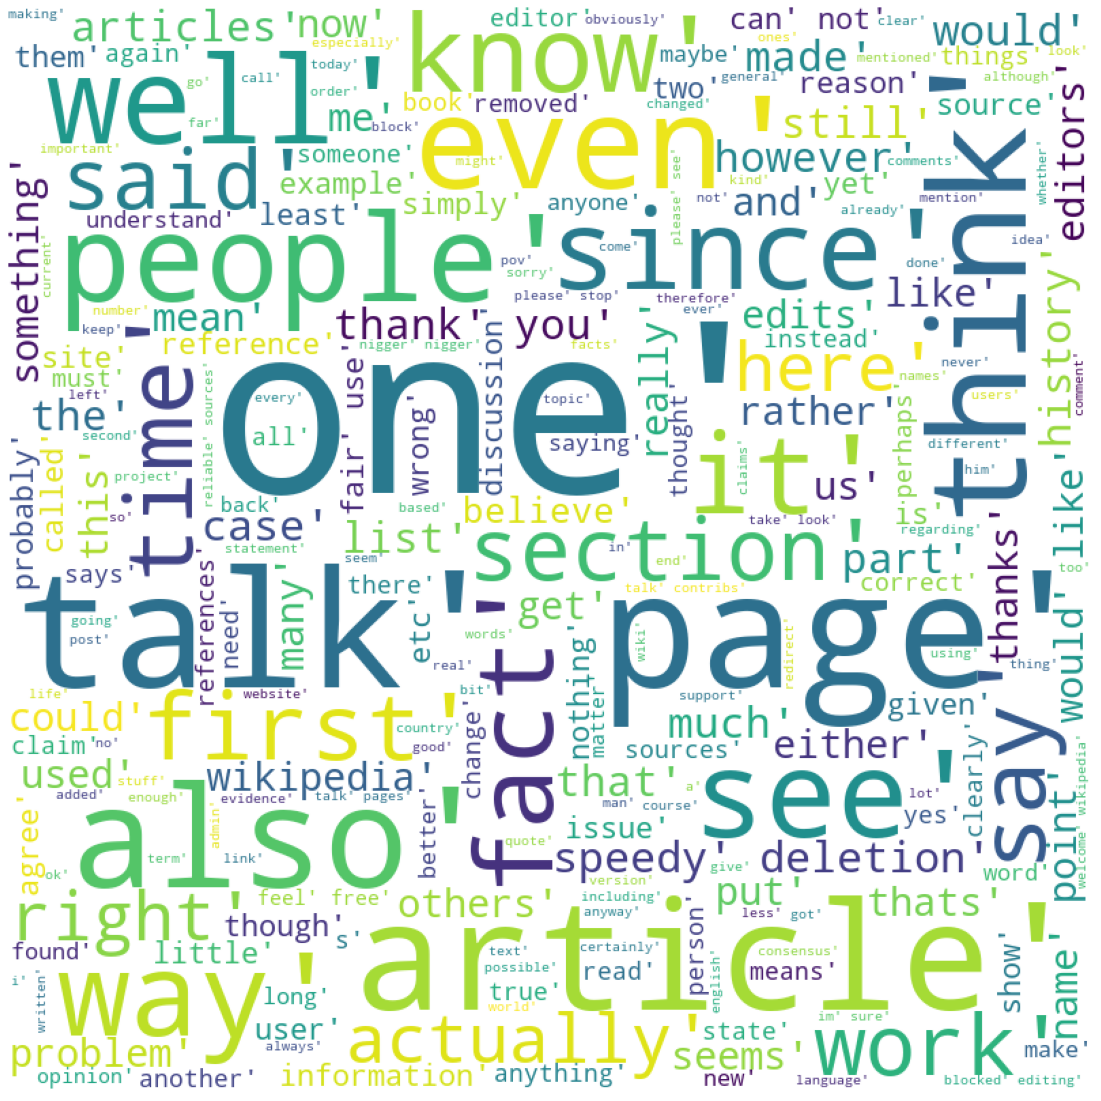

In [ ]:
# визуализируем комментарии
comment_words = ''
for val in df.text:   
    val = str(val)
    tokens = val.split()
    comment_words += " ".join(tokens) + " "
 
wc = WordCloud(width = 800, height = 800,
                background_color ='white', max_words = 1000, 
                min_font_size = 10).generate(comment_words)
                      
plt.figure(figsize = (20,20))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
# разделим данные на признаки и таргет
features = df['text']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=.5, 
                                                                            shuffle=False,
                                                                            random_state=RANDOM_STATE)

In [ ]:
# изменим кодировку данных для обучения
corpus_train = features_train.astype('U')
corpus_test = features_test.astype('U')

In [ ]:
# теперь трансформируем данные используя TF-IDF Vectorizer
count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2))

tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_test = count_tf_idf.transform(corpus_test) 

In [ ]:
# проверим все ли данные корректно разделились
print(f'Обучающие данные: {tf_idf_train.shape}\nТестовые: {tf_idf_test.shape}')

Обучающие данные: (79646, 1675081)
Тестовые: (79646, 1675081)


## Обучение

Теперь переходим к обучению моделей машинного обучения. Обучать будем модели:
* Logistic Regression
* Linear SVC
* LGBM Classifier

### Logistic Regression

In [ ]:
lr = LogisticRegression(random_state=RANDOM_STATE)

In [ ]:
parameters_grid = {'C': [1, 10, 50],
                   'max_iter': [500]}

In [ ]:
grid_search = GridSearchCV(lr, param_grid=parameters_grid, scoring='f1', cv=3, verbose=True)

In [ ]:
grid_search.fit(tf_idf_train, target_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1, 10, 50], 'max_iter': [500]}, scoring='f1',
             verbose=True)

In [ ]:
grid_search.best_params_

{'C': 50, 'max_iter': 500}

In [ ]:
grid_search.best_score_

0.6910456957701668

### Linear SVC

In [ ]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=500)

In [ ]:
parameters_grid = {'C': [1, 10, 50]}

In [ ]:
grid_search = GridSearchCV(svc, parameters_grid, cv=3, scoring = 'f1', verbose=True)

In [ ]:
grid_search.fit(tf_idf_train, target_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=3, estimator=LinearSVC(max_iter=500, random_state=42),
             param_grid={'C': [1, 10, 50]}, scoring='f1', verbose=True)

In [ ]:
grid_search.best_params_

{'C': 50}

In [ ]:
grid_search.best_score_

0.7254171246061117

### LGBM Classifier

In [ ]:
lgmc = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)

In [ ]:
parameters_grid = {'learning_rate': [0.1, 0.3],
                   'n_estimators': [8,16]}

In [ ]:
grid_search = GridSearchCV(lgmc, parameters_grid, scoring ='f1')

In [ ]:
grid_search.fit(tf_idf_train, target_train)

GridSearchCV(estimator=LGBMClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.3], 'n_estimators': [8, 16]},
             scoring='f1')

In [ ]:
grid_search.best_params_

{'learning_rate': 0.3, 'n_estimators': 16}

In [ ]:
grid_search.best_score_

0.7073883084863414

### Проверка лучшей модели на тестовой выборке

Согласно результатам тестирования разных моделей самый лучший F1 получился у **Linear SVC**, поэтому проверим эту модель на тестовом датасете:

In [ ]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=500, C=50)

In [ ]:
svc.fit(tf_idf_train, target_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=50, max_iter=500, random_state=42)

In [ ]:
predict_svc = svc.predict(tf_idf_test)
print('F1 svc:', f1_score(predict_svc, target_test))
print(classification_report(predict_svc, target_test))

F1 svc: 0.7740305843801202
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     73005
           1       0.71      0.85      0.77      6641

    accuracy                           0.96     79646
   macro avg       0.85      0.91      0.88     79646
weighted avg       0.96      0.96      0.96     79646



Text(0.5, 1.05, 'Матрица ошибок')

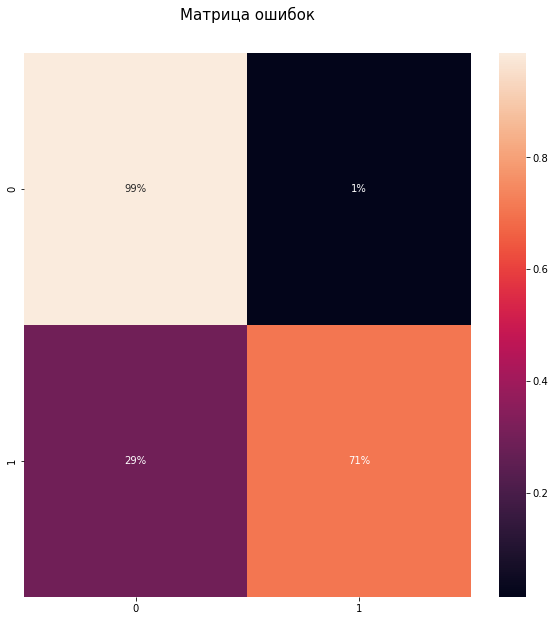

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(target_test, predict_svc, normalize='true'), annot=True,fmt='.0%')
plt.title('Матрица ошибок', y=1.05, size=15)

## Выводы

Для решения задачи классификации комментариев на позитивные и негативные были протестированы 3 модели машинного обучения:
* Logistic Regression
* Linear SVC
* LGBM Classifier

Лучше всего среди исследованных моделей классификацию комментариев выполняет модель Linear SVC, F1 у нее равен **0.774**. Матрица корреляции показала, что процент False Positive и False Negative приемлимый, задача выполнена и модель обучена и корректно работает.